In [1]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoProcessor, AutoModelForZeroShotObjectDetection, AutoModelForCausalLM
from PIL import Image
import matplotlib.pyplot as plt
import torch
import json
import requests
import os

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#model used for captioning image input query
input_processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
input_model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")
#model used for object detection
dino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
coco_dataset = open("instances_val2017.json")
coco_json = json.load(coco_dataset)
coco_images = coco_json["images"]
coco_annotations = coco_json["annotations"]
coco_categories = coco_json["categories"]
inputs_url = []
image_url = []

category_validation_images = {}
id_category_mapping = {}

# Get mappings of id number and category name
for category in coco_categories:
    category_validation_images[category["id"]] = []
    id_category_mapping[category["id"]] = category["name"]

# For each category, get all images with that category annotation
for images in coco_images:
    image_inputs = []
    for anno in coco_annotations:
        if anno["image_id"] == images["id"]:
            for categories in coco_categories:
                if anno["category_id"] == categories["id"]:
                    if images not in category_validation_images[anno["category_id"]]:
                        category_validation_images[anno["category_id"]].append(images)

In [5]:
def plot_results(image, result, category, caption, prompt_image):
    boxes = result["boxes"]
    scores = result["scores"]
    labels = result["labels"]
    fig, axes = plt.subplots(1, 2, figsize = (8, 4))
    plt.axis("off")
    # Plot validation image
    fig.suptitle(f"Category: {category}\nCaption: {caption}")
    axes[0].imshow(image)
    axes[0].set_title("Validation Image")
    axes[0].axis("off")
    colors = plt.cm.hsv(torch.linspace(0, 1, len(boxes))).tolist()
    
    # Add box
    for box, score, label, color in zip(boxes, scores, labels, colors):
        xmin, ymin, xmax, ymax = box.tolist()
        axes[0].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill = False, color = color, linewidth = 2))
        text = f"{label}: {score:.2f}"
        axes[0].text(xmin, ymin, text, bbox = dict(facecolor = "yellow", alpha = 0.5))
    
    # Plot prompt image
    axes[1].imshow(prompt_image)
    axes[1].set_title("Prompt Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

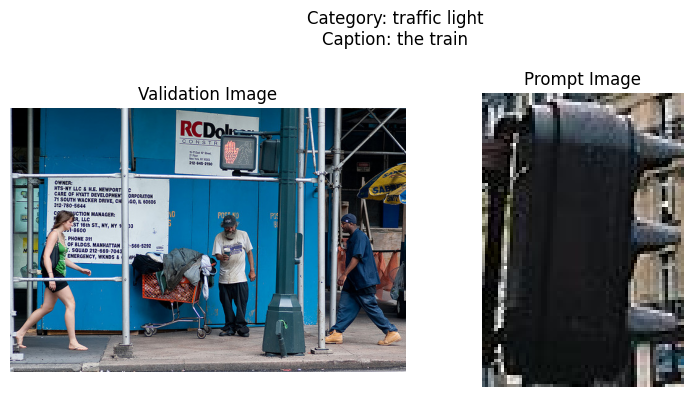

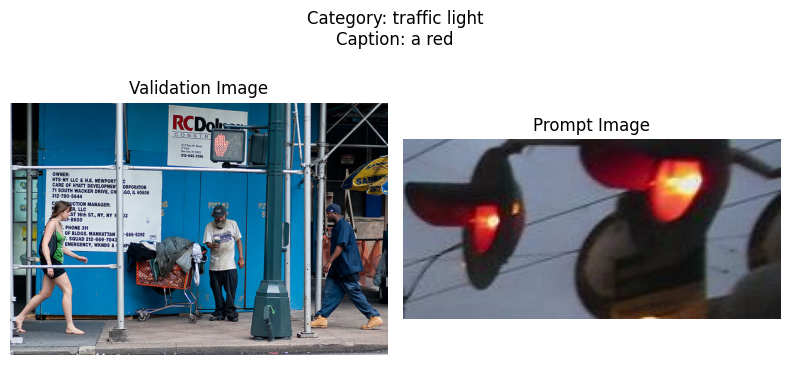

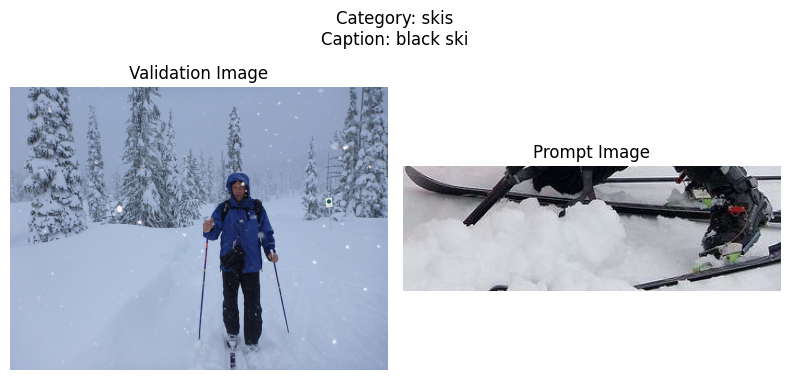

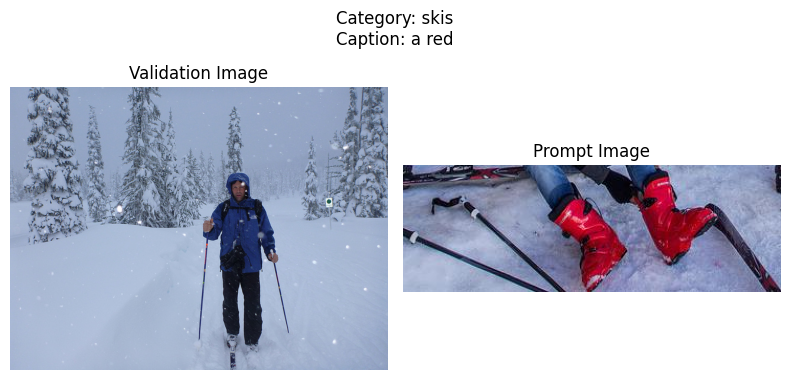

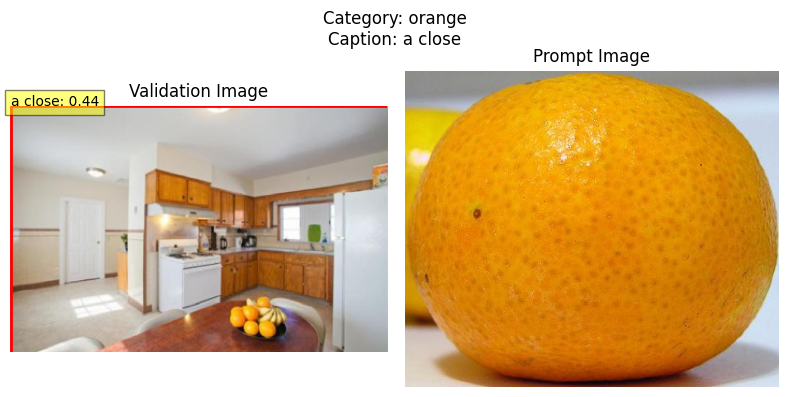

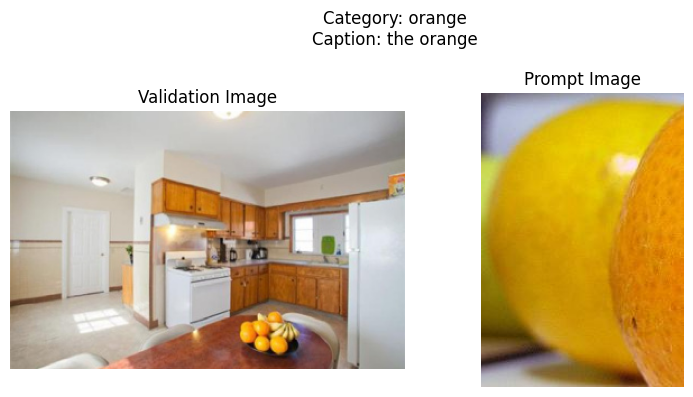

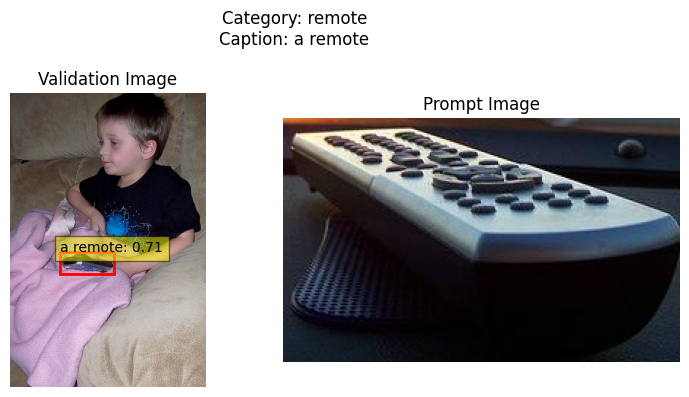

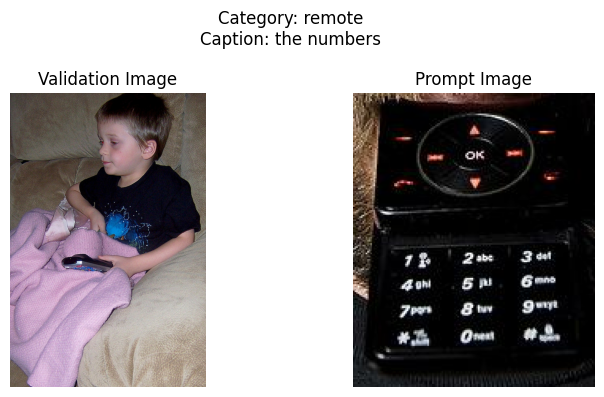

In [9]:
# Number of cropped images in the cateogry to go through
num_cropped_images = 2

# Number of validation images in the category to go through
num_validation_images = 1
category_ids = [10, 35, 55, 75]
# Go through every category
for id in category_ids:
    # All validation images under the category
    images = category_validation_images[id]
    category = id_category_mapping[id]

    # Go thruogh cropped images
    for i in range(num_cropped_images):
        # Open cropped image
        cropped_file = f"./data/cropped_objects/{category}_{i + 1}.jpg"
        prompt_image = Image.open(cropped_file)

        pixel_values = input_processor(images=prompt_image, return_tensors="pt").pixel_values

        generated_ids = input_model.generate(pixel_values=pixel_values, max_new_tokens=2)
        generated_caption = input_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Go through validation iamges
        for i in range(num_validation_images):
            # Open validation image
            image = Image.open(requests.get(images[i]["coco_url"], stream=True).raw)

            # Pass caption and image to grounding dino
            text_labels = [generated_caption]
            inputs = dino_processor(images=image, text=text_labels, return_tensors="pt")
            with torch.no_grad():
                outputs = dino_model(**inputs)
            results = dino_processor.post_process_grounded_object_detection(
                outputs,
                inputs.input_ids,
                box_threshold=0.4,
                text_threshold=0.3,
                target_sizes=[image.size[::-1]]
            )

            # Plot output and prompt image
            plot_results(image, results[0], category, generated_caption, prompt_image)